In [1]:
!pip install gymnasium[mujoco]
!pip install torch
!pip install omegaconf

In [2]:
import os
import sys
import random

from tqdm import tqdm
from collections import deque
from omegaconf import OmegaConf

import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# conf = OmegaConf({
#     'state_dim': ,
#     'action_dim': ,
#     'hidden_dims': ,
#     'activation_fn': ,
#     'n_steps': 2048,
#     'n_epochs': 10,
#     'batch_size': 64,
#     'policy_lr': 0.0003,
#     'value_lr': 0.0003,
#     'gamma': 0.99,
#     'lmda': 0.95,
#     'clip_ratio': 0.2,
#     'vf_coef': 1.0,
#     'ent_coef': 0.01,


# })

In [4]:
class PPO:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(64, 64 ),
        activation_fn=torch.tanh,
        n_steps=2048,
        n_epochs=10,
        batch_size=64,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
        lmda=0.95,
        clip_ratio=0.2,
        vf_coef=1.0,
        ent_coef=0.01,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)
        self.n_steps = n_steps
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lmda = lmda
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)

        self.buffer = RolloutBuffer()

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()

    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])

        # GAE 및 log_prob_old 계산
        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)  # \delta_t 담은 배열
            adv = torch.clone(delta)  # gae를 담을 배열
            ret = torch.clone(r) # return을 담을 배열
            for t in reversed(range(len(r) - 1)):
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]

            # \pi_{old}(a|s) 로그 확률 값 계산하기
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
            log_prob_old = m.log_prob(z).sum(dim=-1, keepdims=True)

        # Training the policy and value network ``n_epochs`` time
        dts = TensorDataset(s, a, ret, adv, log_prob_old)
        loader = DataLoader(dts, batch_size=self.batch_size, shuffle=True)
        for e in range(self.n_epochs):
            value_losses, policy_losses, entropy_bonuses = [], [], []
            for batch in loader:
                s_, a_, ret_, adv_, log_prob_old_ = batch
                # 가치 네트워크의 손실함수 계산
                value = self.value(s_)
                value_loss = F.mse_loss(value, ret_)

                # 정책 네트워크의 손실함수 계산
                mu, std = self.policy(s_)
                m = Normal(mu, std)
                z = torch.atanh(torch.clamp(a_, -1.0 + 1e-7, 1.0 - 1e-7))
                log_prob = m.log_prob(z).sum(dim=-1, keepdims=True)

                ratio = (log_prob - log_prob_old_).exp()
                surr1 = adv_ * ratio
                surr2 = adv_ * torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)

                policy_loss = -torch.min(surr1, surr2).mean()
                entropy_bonus = -m.entropy().mean()

                loss = policy_loss + self.vf_coef * value_loss + self.ent_coef * entropy_bonus
                self.value_optimizer.zero_grad()
                self.policy_optimizer.zero_grad()
                loss.backward()
                self.value_optimizer.step()
                self.policy_optimizer.step()

                value_losses.append(value_loss.item())
                policy_losses.append(policy_loss.item())
                entropy_bonuses.append(-entropy_bonus.item())

        result = {'policy_loss': np.mean(policy_losses),
                  'value_loss': np.mean(value_losses),
                  'entropy_bonus': np.mean(entropy_bonuses)}

        return result

    def step(self, transition):
        result = None
        self.buffer.store(transition)
        if self.buffer.size >= self.n_steps:
            result = self.learn()

        return result

In [5]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)

In [6]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

In [7]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [8]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [9]:
env_name = 'Hopper-v4'

seed = 0
seed_all(seed)
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
activation_fn = F.relu

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = PPO(
    state_dim,
    action_dim,
    activation_fn=activation_fn,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime

    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
        logger.append([t, 'entropy_bonus', result['entropy_bonus']])

    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False

    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [30:45<00:00, 541.96it/s]


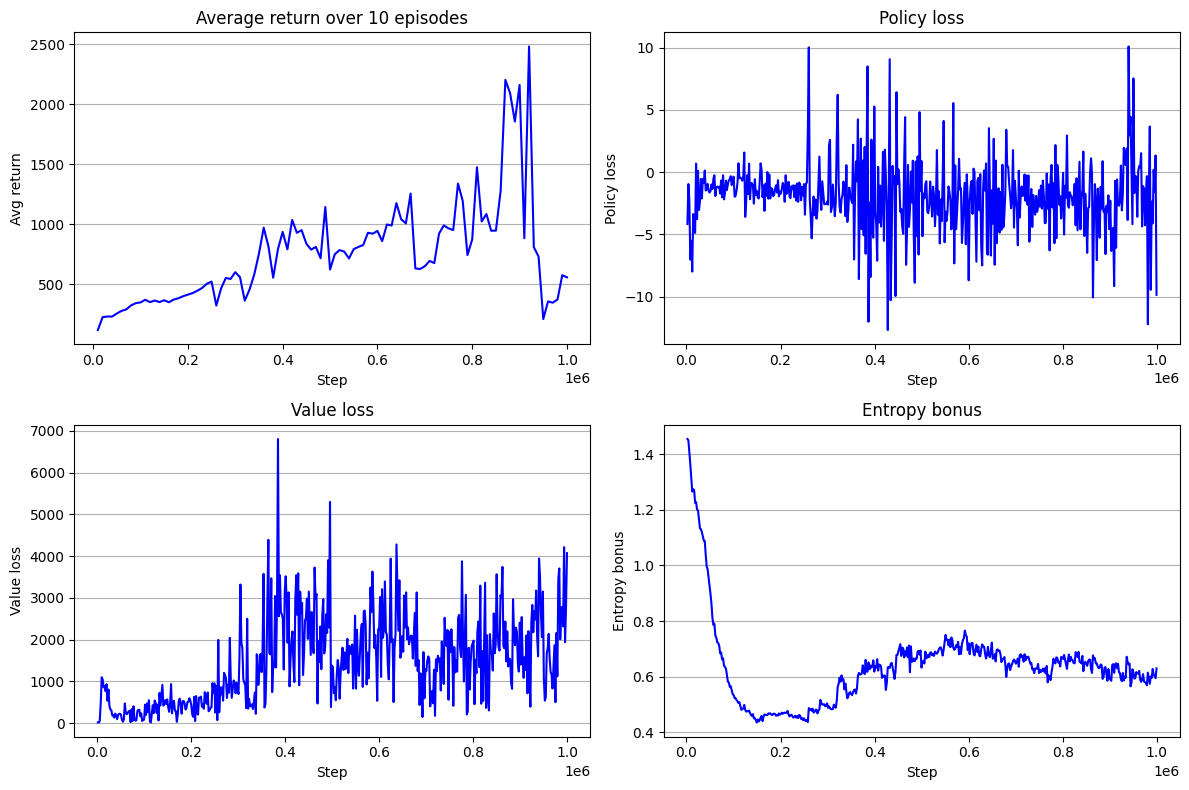

In [10]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(2, 2, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(2, 2, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(2, 2, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

ax = fig.add_subplot(2, 2, 4)
key = 'entropy_bonus'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Entropy bonus")
ax.set_xlabel("Step")
ax.set_ylabel("Entropy bonus")

fig.tight_layout()
plt.show()